# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Niklas Gunnarsson, Carl Andersson, Daniel Gedon

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Joana Palés Huix and Adam Orucu</font>
- **Team ID:** <font color='red'>Team</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health.
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam.


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/42324/assignments/254507

**Due Date:** August 25, 2023.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks.

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long.

In [1]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [2]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [3]:
!git clone https://github.com/klean2050/ecg-augmentations
!pip install -e ecg-augmentations

fatal: destination path 'ecg-augmentations' already exists and is not an empty directory.
Obtaining file:///content/ecg-augmentations
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ecg-augmentations
    Found existing installation: ecg-augmentations 0.1.0
    Uninstalling ecg-augmentations-0.1.0:
      Successfully uninstalled ecg-augmentations-0.1.0
  Running setup.py develop for ecg-augmentations


In [4]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
from ecg_augmentations import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels.
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [5]:
# 1. Download dataset
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

--2023-08-10 11:54:32--  https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9zkqa5y5jqakdil/codesubset.tar.gz [following]
--2023-08-10 11:54:32--  https://www.dropbox.com/s/raw/9zkqa5y5jqakdil/codesubset.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb8780e9914e85d782252abf8e4.dl.dropboxusercontent.com/cd/0/inline/CBjVJtq_Zy2Ixo05n5eXhmoSoAdVaNlyM1_GyPgWp3MnDYYjvDA4kiRH542K1tg7GvkQg_aGWL__bUmK1U9b5KVVSP6OMXaldhiM7Gdwztg1kBdYO6z6Tk7MFtcLIOVl2OY/file# [following]
--2023-08-10 11:54:33--  https://ucb8780e9914e85d782252abf8e4.dl.dropboxusercontent.com/cd/0/inline/CBjVJtq_Zy2Ixo05n5eXhmoSoAdVaNlyM1_GyPgWp3MnDYYjvDA4kiRH542K1tg7GvkQg_aGWL__bUmK1U9b5KVVSP6OMXaldhiM

In [6]:
# 1. unzip the downloaded data set folder
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [7]:
# 2. clone the code files for data preprocessing
if not exists('ecg-preprocessing'):
    !git clone https://github.com/antonior92/ecg-preprocessing.git

Cloning into 'ecg-preprocessing'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 43 (delta 19), reused 32 (delta 12), pack-reused 0
Receiving objects: 100% (43/43), 386.28 KiB | 11.36 MiB/s, done.
Resolving deltas: 100% (19/19), done.


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

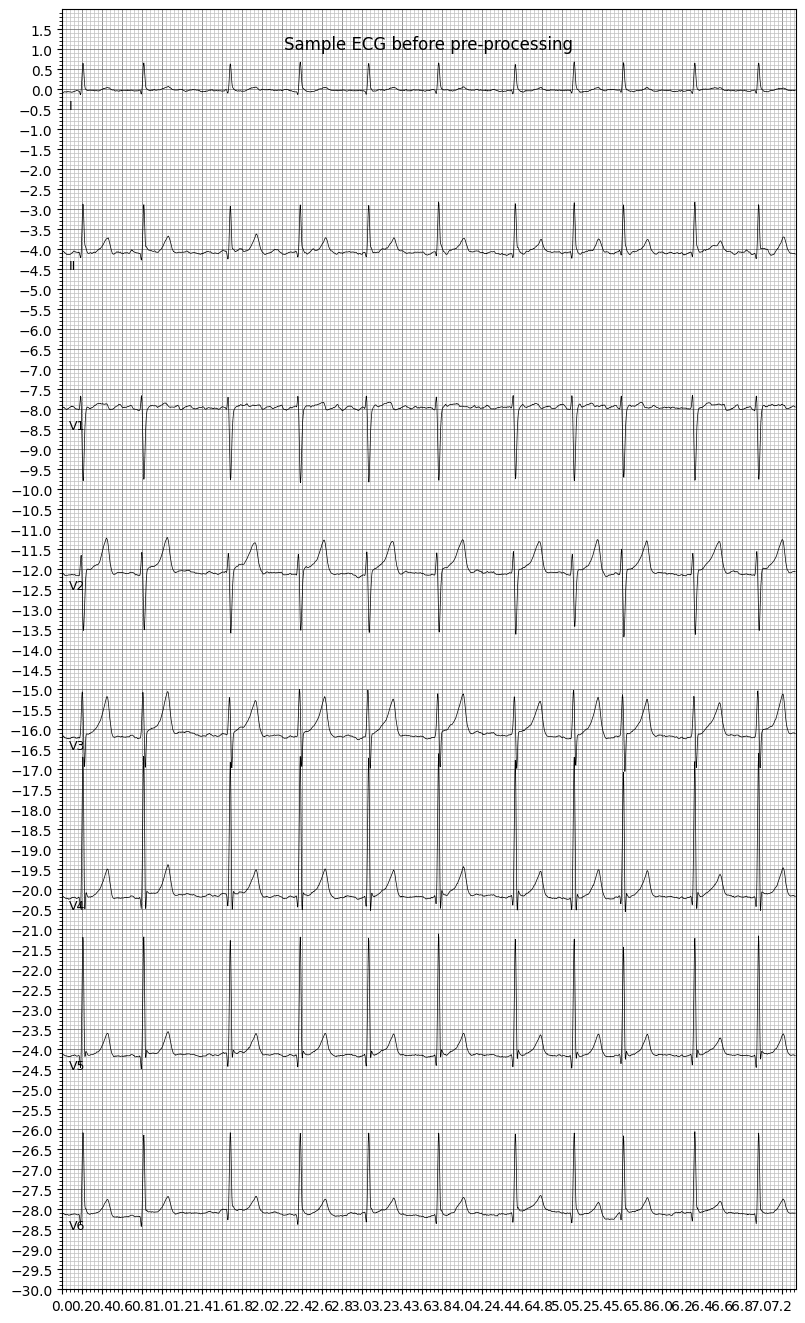

In [8]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


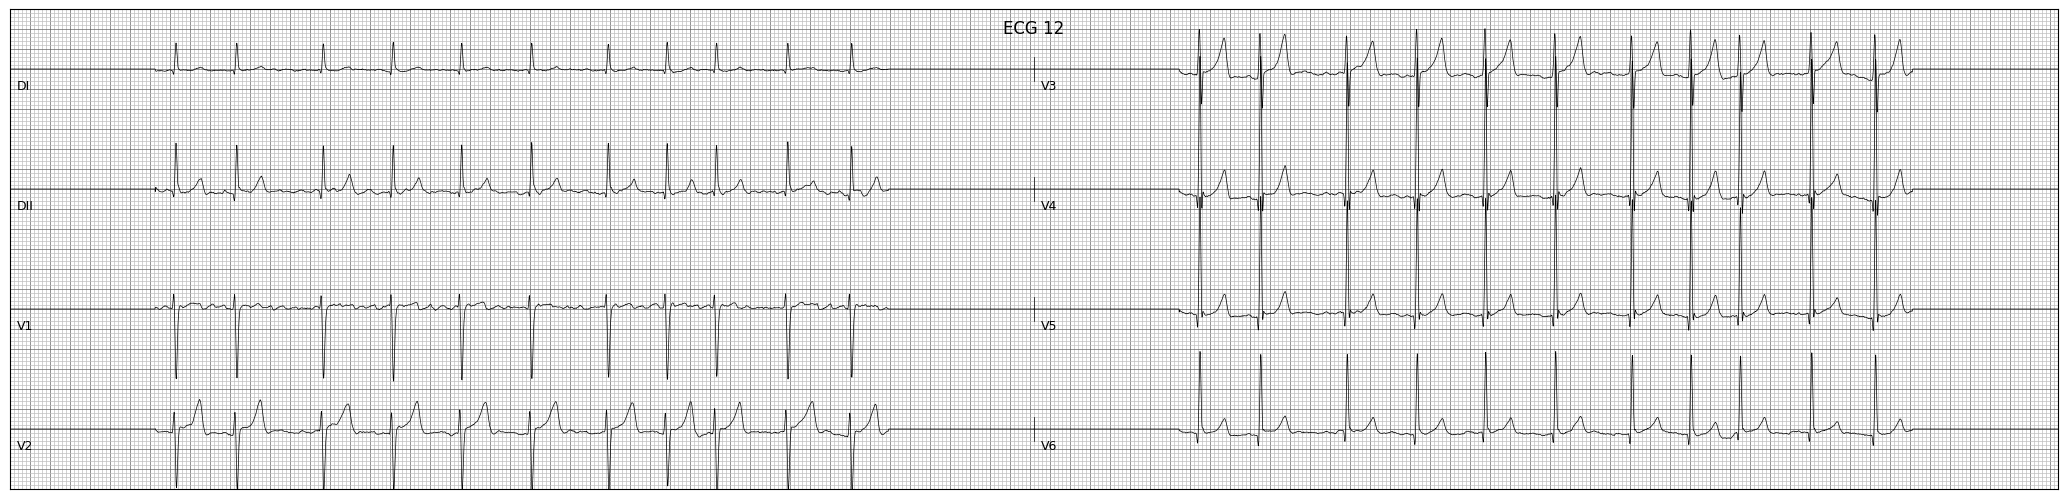

<Figure size 640x480 with 0 Axes>

In [9]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8.
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [10]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

Namespace(input_file='codesubset/train/RECORDS.txt', out_file='codesubset/train.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 10000/10000 [01:21<00:00, 123.27it/s]
Namespace(input_file='codesubset/test/RECORDS.txt', out_file='codesubset/test.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 6000/6000 [00:50<00:00, 119.61it/s]


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


In [11]:
"""
TASK: Insert your code here
"""
import h5py
PATH_TO_H5_FILE = 'codesubset/train.h5'
path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'

# Load ecg
traces = torch.tensor(h5py.File(PATH_TO_H5_FILE, 'r')['tracings'][()], dtype=torch.float32)

# Load metadata
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same


<Figure size 640x480 with 0 Axes>

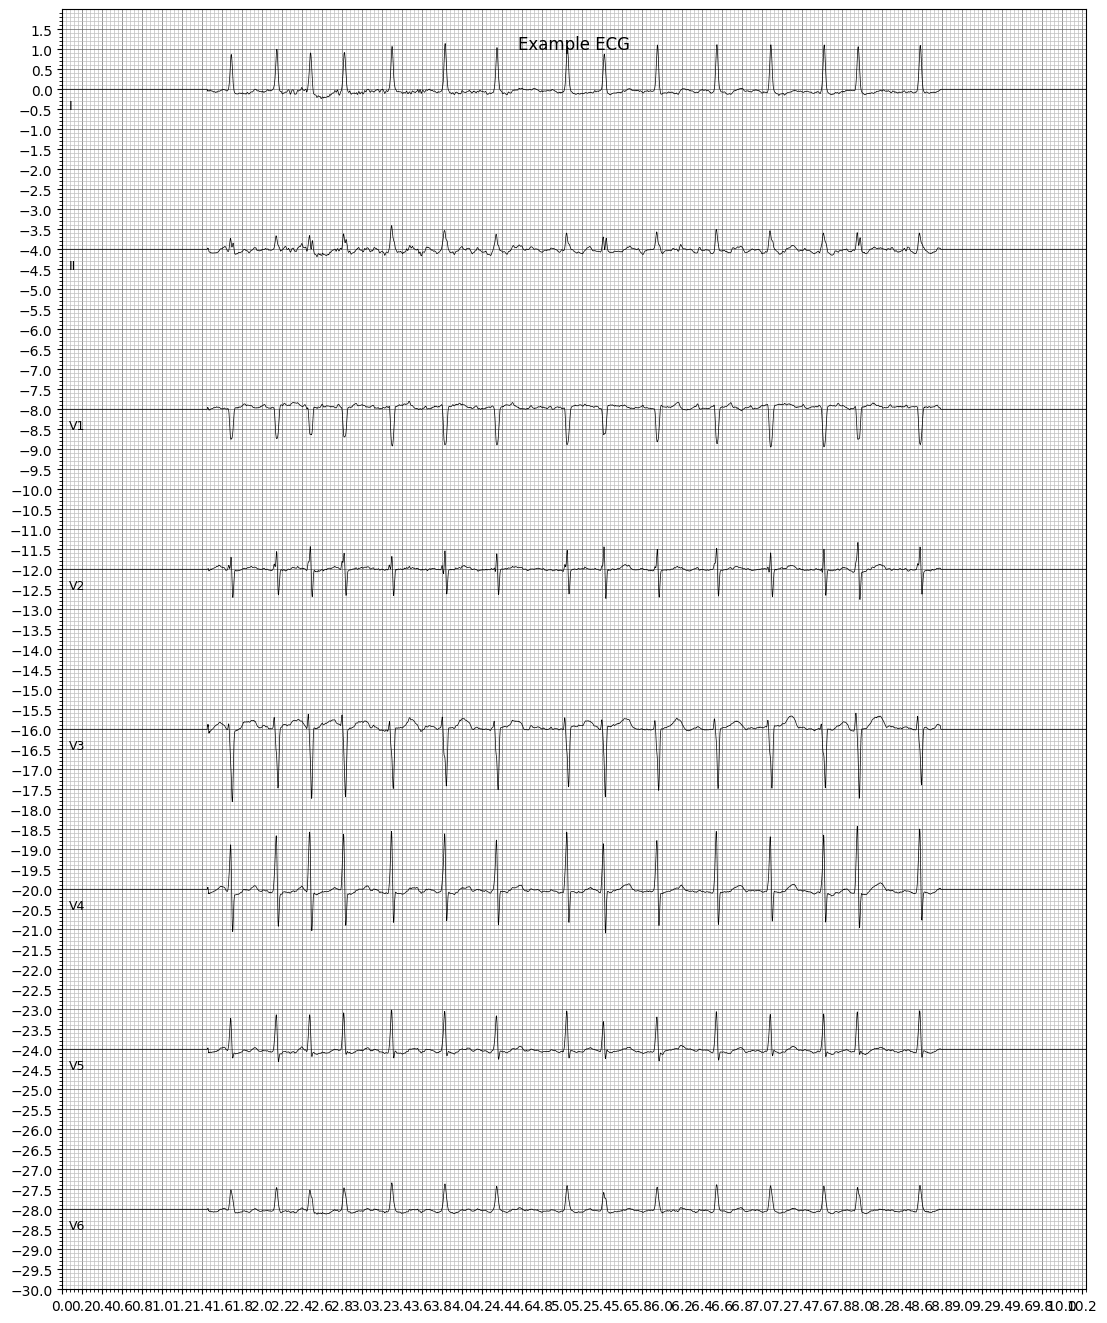

<Figure size 640x480 with 0 Axes>

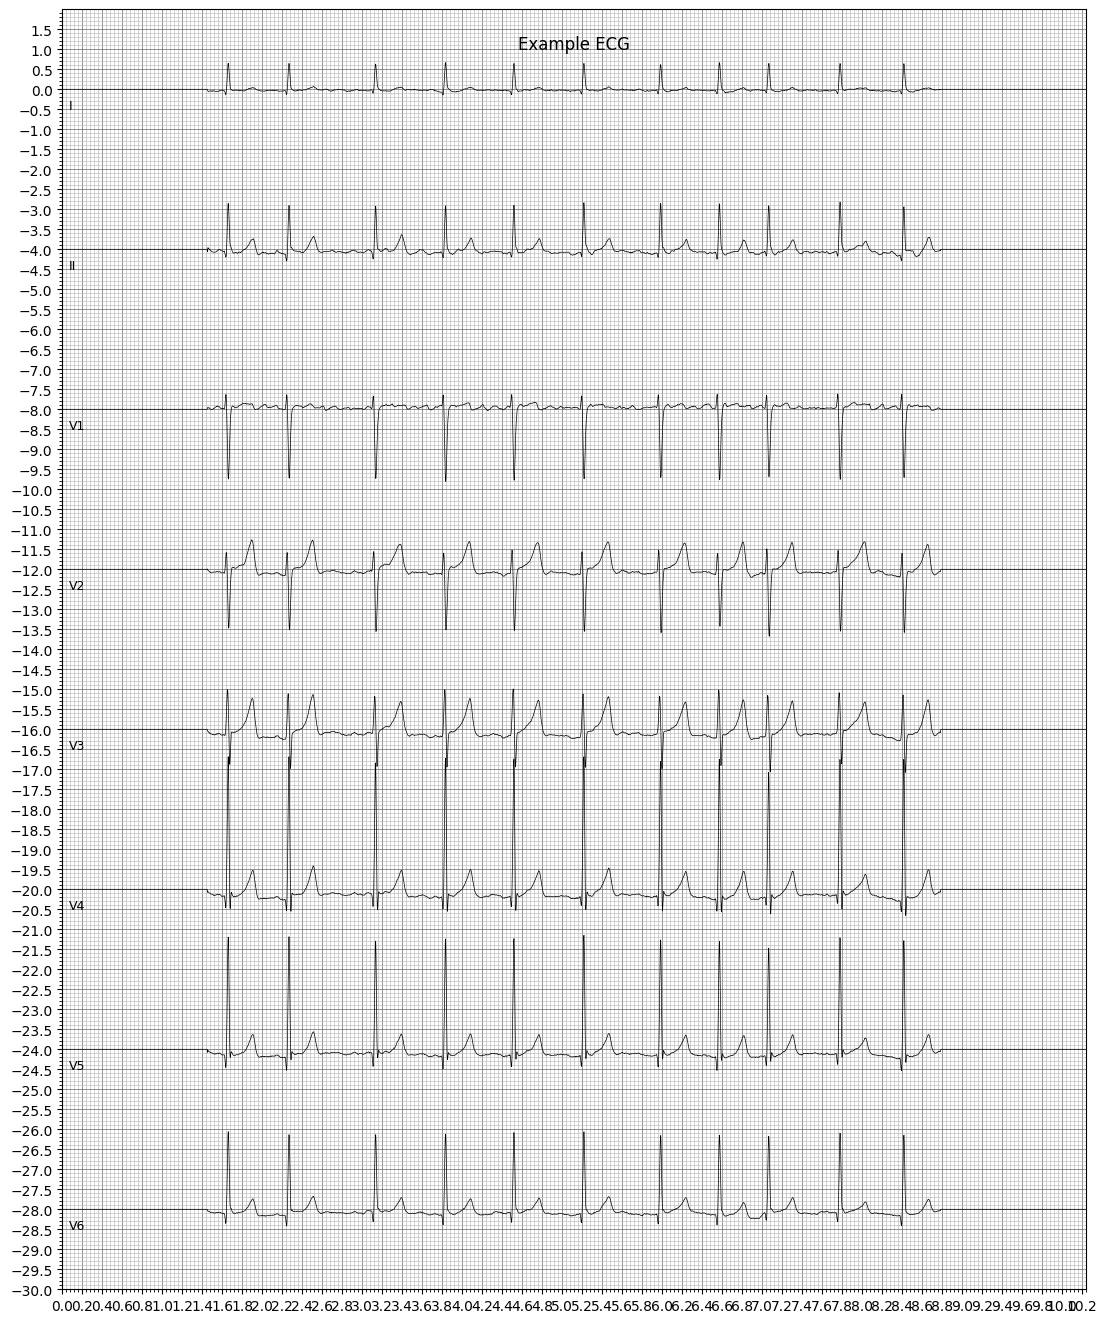

In [12]:
# Plot an ecg example from both classes

import ecg_plot

lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

plt.figure()
ecg_plot.plot(traces[-1,:,:].permute(1,0), sample_rate=400, style='bw', row_height=8, lead_index=lead, columns=1, title='Example ECG')
plt.show()

plt.figure()
ecg_plot.plot(traces[0,:,:].permute(1,0), sample_rate=400, style='bw', row_height=8, lead_index=lead, columns=1, title='Example ECG')
plt.show()

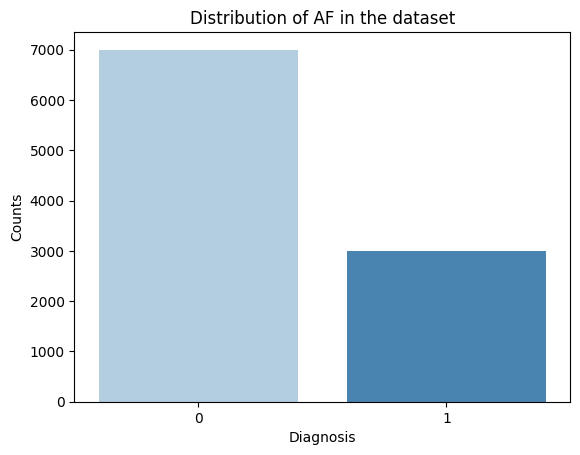

In [13]:
# Plot diagnosis distribution
labels = np.array(df['AF']).reshape(-1,1)
l, c = np.unique(labels, return_counts=True)
fig, ax = plt.subplots()
g = sns.barplot(x=l, y=c, palette='Blues')
plt.title("Distribution of AF in the dataset")
plt.ylabel("Counts")
plt.xlabel("Diagnosis")
plt.show()

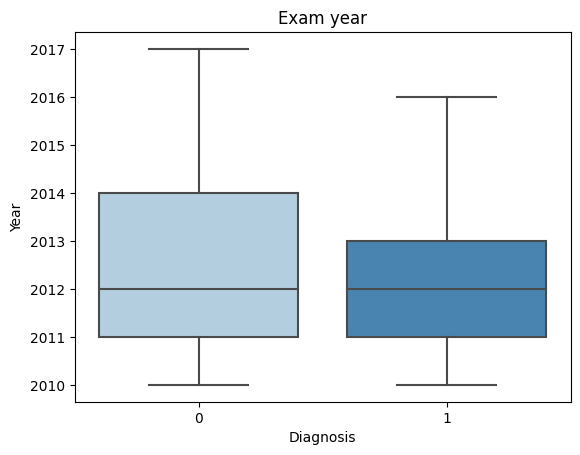

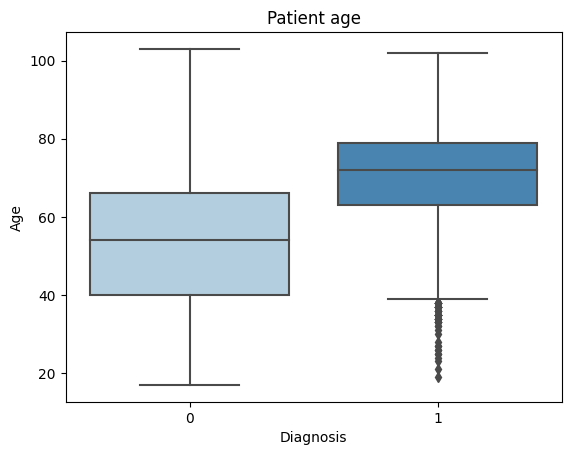

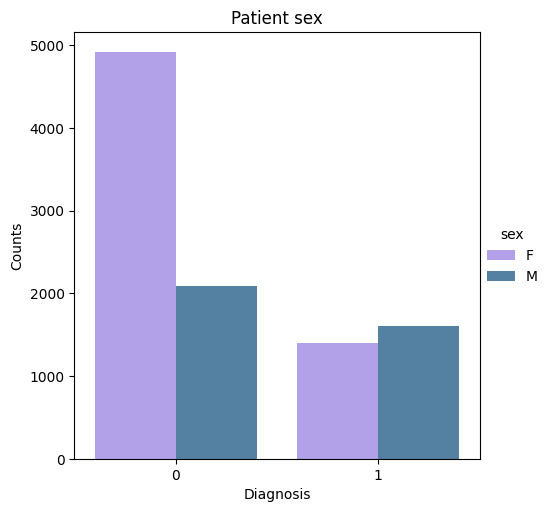

In [14]:
## Plot other metadata

# Exam year
df['year'] = df['date_exam'].str.split('-').str[0].astype(int)
g = sns.boxplot(x="AF", y="year", data=df, palette='Blues')
plt.title("Exam year")
plt.ylabel("Year")
plt.xlabel("Diagnosis")
plt.show()

# Age
g = sns.boxplot(x="AF", y="age", data=df, palette='Blues')
plt.title("Patient age")
plt.ylabel("Age")
plt.xlabel("Diagnosis")
plt.show()

# Sex
count_df = df.groupby(["sex", "AF"]).size().to_frame(name='Count').reset_index()
g = sns.catplot(data=count_df, kind="bar",x="AF", y="Count", hue="sex", palette=sns.color_palette(['#AC94F4','#4783af']))
sns.despine(top=False, right = False)
plt.title("Patient sex")
plt.ylabel("Counts")
plt.xlabel("Diagnosis")
plt.show()


### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color='red'>Your explanation here:</font>**


Main data inspection:

- Visual differences between negative and positive diagnoses of Atrial Fibrillation appear to be represented by the irregularity of the ECG signal.
- The dataset exhibits class imbalance, with more than double the number of positive cases. This imbalance may lead to challenges during training. A naive classifier would achieve an accuracy of around 70%, deviating from the expected 50% accuracy on a balanced dataset.

Other details explored that might impact model performance in a clinical setting:

- The dataset shows a higher proportion of females than males, and a greater portion of females received a negative diagnosis. This disparity could introduce biases in the model's performance when testing on female data, potentially leading to an overrepresentation of negative diagnoses (label 0) if the model inadvertently infers sex from the ECG signals.
- Age seems to play a role in the ease of diagnosing AF, with older patients being more readily diagnosed.
- The majority of exams were conducted around 2012. This temporal aspect may affect the model's generalization to new exams taken with different ECG machines.

Preprocessing:

- The baseline, representing the lower frequency, is removed to center the ECG signal around 0.
- The powerline frequency is eliminated to avoid interference.
- Data is resampled to a standardized sample rate of 400, promoting consistency across signals.
- Signal length is adjusted to 4096 data points.


---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [15]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**
- The depth of the CNN has been increased to enable more detailed representation of the data and therefore improve the predictive performance.
- The architecture has been modelled according [to a paper](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-021-01736-y/tables/1) aiming to solve a similar goal. This way we roughly new what size of network is needed.
- The pooling layers reduce the dimetions of the outputs from layers and therefore improving the efficiency of the model and potentially helping with overfitting.
- We have added batch normalisation to stabilise the training and therefore get a higher performance and dropout for get more robust models.

---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [17]:

def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    total_ones = 0
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)
        total_ones += torch.sum(diagnoses)
        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        optimizer.zero_grad()
        output = model(traces)
        loss = loss_function(output, diagnoses)
        loss.backward()
        optimizer.step()

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    print(f"Percentage of ones: {100 * total_ones / n_entries}")
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [18]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        with torch.no_grad():
            output = model(traces)
            loss = loss_function(output, diagnoses)

            # preds = torch.round(output)
            preds = output
            valid_pred.append(preds.cpu().numpy())
            valid_true.append(diagnoses.cpu().numpy())

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**

The hyperparameters have been fine-tuned through a small search around typical values for this type of small CNN and the specific task at hand. The tuning process aimed to maximize performance on the validation set while ensuring a balance across all metrics.

- Learning rate: A higher learning rate appeared to yield better results. In later models, a scheduler was implemented to reduce the learning rate by a factor of 0.25 every 15 epochs.
- Weight decay: We chose not to use weight decay, as it didn't show improvements in performance.
- Number of epochs: To ensure effective learning, we selected a relatively high number of epochs. Since the best model is chosen based on validation loss, overfitting is not a major concern.
- Batch size: A larger batch size was employed to expedite training. This value was offset by tuning the learning rate accordingly.
- Augmentations: Various augmentations were tested and implemented, this created more samples for the model to learn from.

In [19]:
from torch.utils.data import TensorDataset, random_split, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from ecg_augmentations import *

class AugmentedTensorDataset(TensorDataset):

    def __init__(self, func, *tensors):
        super(AugmentedTensorDataset, self).__init__(*tensors)
        self.t = func

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        img = img.permute(1,0)
        try:
            augmented_img = self.t(img)
        except:
            # skip augmentation errors due to specific ECG morphology
            augmented_img = img
        return augmented_img.permute(1,0), label

In [20]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-3
weight_decay =  0 #1e-2
num_epochs = 60
batch_size = 64

# Choose the augmentations
transforms = [
    #RandomApply([Permute()], p=0.6),
    RandomApply([PRMask(sample_rate=400, ratio=0.1)], p=0.4),
    RandomApply([Scale(max_factor=2)], p=0.4),
    GaussianNoise(max_snr=0.005),
    RandomApply([Invert()], p=0.2),
    RandomApply([Reverse()], p=0.2),
    ]
augmentations = Compose(transforms=transforms)

In [21]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
dataset_aug = AugmentedTensorDataset(augmentations, traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
dataset_train, dataset_valid = random_split(dataset, [int(len_dataset*0.8), int(len_dataset*0.2)], torch.Generator().manual_seed(34123))
# Augmentations
dataset_train_aug, _ = random_split(dataset_aug, [int(len_dataset*0.8), int(len_dataset*0.2)], torch.Generator().manual_seed(34123))

# Weighted Random Sampler
counts = np.bincount(labels.reshape(-1))
sample_weights = [1/counts[int(i[0])] for i in labels]
train_sample_weights = [sample_weights[i] for i in dataset_train.indices]
len(train_sample_weights)
sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(dataset_train), replacement=True)

# build data loaders
# train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(dataset_train_aug, batch_size=batch_size, sampler=sampler)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")


Use device: cuda

Building data loaders...
Done!



Define model...
Done!

Define optimiser...
Done!

Adjusting learning rate of group 0 to 1.0000e-03.
Training...


  0%|          | 0/60 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.375003814697266


Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.910, Precision: 0.716, Recall: 0.822, F1: 0.765, Acc: 0.853
Epoch  1: 	Train Loss 0.008178 	Valid Loss 0.005621 	Best model -> saved
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch  2:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.750003814697266


Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.951, Precision: 0.725, Recall: 0.940, F1: 0.818, Acc: 0.878
Epoch  2: 	Train Loss 0.006276 	Valid Loss 0.005087 	Best model -> saved
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch  3:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.05000305175781


Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.958, Precision: 0.868, Recall: 0.863, F1: 0.865, Acc: 0.921
Epoch  3: 	Train Loss 0.005638 	Valid Loss 0.003755 	Best model -> saved
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch  4:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.67500305175781


Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.959, Precision: 0.884, Recall: 0.860, F1: 0.872, Acc: 0.926
Epoch  4: 	Train Loss 0.005229 	Valid Loss 0.003473 	Best model -> saved
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch  5:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.42500305175781


Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.965, Precision: 0.840, Recall: 0.926, F1: 0.881, Acc: 0.927
Epoch  5: 	Train Loss 0.005106 	Valid Loss 0.003461 	Best model -> saved
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch  6:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.63750076293945


Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.967, Precision: 0.819, Recall: 0.926, F1: 0.869, Acc: 0.918
Epoch  6: 	Train Loss 0.004801 	Valid Loss 0.003601 	
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch  7:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.48750305175781


Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.966, Precision: 0.872, Recall: 0.906, F1: 0.889, Acc: 0.933
Epoch  7: 	Train Loss 0.004402 	Valid Loss 0.003088 	Best model -> saved
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch  8:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.70000076293945


Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.967, Precision: 0.915, Recall: 0.889, F1: 0.902, Acc: 0.944
Epoch  8: 	Train Loss 0.004494 	Valid Loss 0.002625 	Best model -> saved
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch  9:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.38750076293945


Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.972, Precision: 0.801, Recall: 0.945, F1: 0.867, Acc: 0.915
Epoch  9: 	Train Loss 0.004268 	Valid Loss 0.003702 	
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.82500076293945


Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.971, Precision: 0.801, Recall: 0.959, F1: 0.873, Acc: 0.918
Epoch 10: 	Train Loss 0.004211 	Valid Loss 0.003685 	
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.30000305175781


Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.972, Precision: 0.913, Recall: 0.880, F1: 0.896, Acc: 0.941
Epoch 11: 	Train Loss 0.004186 	Valid Loss 0.002533 	Best model -> saved
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 51.16250228881836


Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.973, Precision: 0.784, Recall: 0.966, F1: 0.865, Acc: 0.912
Epoch 12: 	Train Loss 0.003998 	Valid Loss 0.003900 	
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.78750228881836


Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.961, Precision: 0.941, Recall: 0.846, F1: 0.891, Acc: 0.940
Epoch 13: 	Train Loss 0.003874 	Valid Loss 0.002655 	
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.53750228881836


Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.974, Precision: 0.874, Recall: 0.940, F1: 0.906, Acc: 0.943
Epoch 14: 	Train Loss 0.003961 	Valid Loss 0.002669 	
Adjusting learning rate of group 0 to 1.0000e-03.


Training Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.72500228881836


Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.972, Precision: 0.816, Recall: 0.957, F1: 0.881, Acc: 0.924
Epoch 15: 	Train Loss 0.003709 	Valid Loss 0.003326 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 51.187503814697266


Evaluation Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.875, Recall: 0.947, F1: 0.910, Acc: 0.945
Epoch 16: 	Train Loss 0.003465 	Valid Loss 0.002448 	Best model -> saved
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.63750076293945


Evaluation Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.976, Precision: 0.908, Recall: 0.933, F1: 0.921, Acc: 0.953
Epoch 17: 	Train Loss 0.003439 	Valid Loss 0.002326 	Best model -> saved
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.28750228881836


Evaluation Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.976, Precision: 0.887, Recall: 0.944, F1: 0.915, Acc: 0.949
Epoch 18: 	Train Loss 0.003292 	Valid Loss 0.002474 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.66250228881836


Evaluation Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.977, Precision: 0.899, Recall: 0.944, F1: 0.921, Acc: 0.953
Epoch 19: 	Train Loss 0.003188 	Valid Loss 0.002354 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 20:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.775001525878906


Evaluation Epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.976, Precision: 0.919, Recall: 0.932, F1: 0.925, Acc: 0.956
Epoch 20: 	Train Loss 0.003351 	Valid Loss 0.002116 	Best model -> saved
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 21:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.687503814697266


Evaluation Epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.980, Precision: 0.898, Recall: 0.949, F1: 0.923, Acc: 0.954
Epoch 21: 	Train Loss 0.003299 	Valid Loss 0.002208 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 22:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.275001525878906


Evaluation Epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.977, Precision: 0.920, Recall: 0.940, F1: 0.930, Acc: 0.959
Epoch 22: 	Train Loss 0.003285 	Valid Loss 0.002129 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 23:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.837501525878906


Evaluation Epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.977, Precision: 0.896, Recall: 0.945, F1: 0.920, Acc: 0.952
Epoch 23: 	Train Loss 0.003316 	Valid Loss 0.002298 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 24:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.48750305175781


Evaluation Epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.981, Precision: 0.883, Recall: 0.954, F1: 0.917, Acc: 0.950
Epoch 24: 	Train Loss 0.003272 	Valid Loss 0.002470 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 25:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.55000305175781


Evaluation Epoch 25:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.908, Recall: 0.940, F1: 0.924, Acc: 0.955
Epoch 25: 	Train Loss 0.003162 	Valid Loss 0.002274 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 26:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.625003814697266


Evaluation Epoch 26:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.975, Precision: 0.918, Recall: 0.932, F1: 0.925, Acc: 0.956
Epoch 26: 	Train Loss 0.003224 	Valid Loss 0.002162 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 27:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.16250228881836


Evaluation Epoch 27:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.975, Precision: 0.915, Recall: 0.935, F1: 0.925, Acc: 0.956
Epoch 27: 	Train Loss 0.003021 	Valid Loss 0.002212 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 28:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.53750228881836


Evaluation Epoch 28:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.872, Recall: 0.956, F1: 0.912, Acc: 0.946
Epoch 28: 	Train Loss 0.003067 	Valid Loss 0.002652 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 29:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.01250076293945


Evaluation Epoch 29:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.974, Precision: 0.926, Recall: 0.916, F1: 0.921, Acc: 0.954
Epoch 29: 	Train Loss 0.003103 	Valid Loss 0.002221 	
Adjusting learning rate of group 0 to 2.5000e-04.


Training Epoch 30:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.625003814697266


Evaluation Epoch 30:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.977, Precision: 0.853, Recall: 0.962, F1: 0.904, Acc: 0.941
Epoch 30: 	Train Loss 0.003120 	Valid Loss 0.002915 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 31:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.025001525878906


Evaluation Epoch 31:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.981, Precision: 0.892, Recall: 0.950, F1: 0.921, Acc: 0.952
Epoch 31: 	Train Loss 0.002842 	Valid Loss 0.002261 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 32:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.500003814697266


Evaluation Epoch 32:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.905, Recall: 0.944, F1: 0.924, Acc: 0.955
Epoch 32: 	Train Loss 0.002706 	Valid Loss 0.002146 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 33:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.775001525878906


Evaluation Epoch 33:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.978, Precision: 0.903, Recall: 0.944, F1: 0.923, Acc: 0.954
Epoch 33: 	Train Loss 0.002788 	Valid Loss 0.002184 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 34:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.72500228881836


Evaluation Epoch 34:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.892, Recall: 0.945, F1: 0.918, Acc: 0.951
Epoch 34: 	Train Loss 0.003031 	Valid Loss 0.002245 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 35:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.32500076293945


Evaluation Epoch 35:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.896, Recall: 0.947, F1: 0.921, Acc: 0.953
Epoch 35: 	Train Loss 0.002845 	Valid Loss 0.002210 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 36:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.51250076293945


Evaluation Epoch 36:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.978, Precision: 0.887, Recall: 0.952, F1: 0.918, Acc: 0.951
Epoch 36: 	Train Loss 0.002720 	Valid Loss 0.002350 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 37:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.61250305175781


Evaluation Epoch 37:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.981, Precision: 0.904, Recall: 0.950, F1: 0.927, Acc: 0.956
Epoch 37: 	Train Loss 0.002893 	Valid Loss 0.002215 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 38:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.97500228881836


Evaluation Epoch 38:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.981, Precision: 0.901, Recall: 0.952, F1: 0.926, Acc: 0.956
Epoch 38: 	Train Loss 0.002760 	Valid Loss 0.002188 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 39:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.95000076293945


Evaluation Epoch 39:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.980, Precision: 0.900, Recall: 0.954, F1: 0.926, Acc: 0.956
Epoch 39: 	Train Loss 0.002604 	Valid Loss 0.002342 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 40:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.92500305175781


Evaluation Epoch 40:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.980, Precision: 0.910, Recall: 0.949, F1: 0.929, Acc: 0.958
Epoch 40: 	Train Loss 0.002686 	Valid Loss 0.002198 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 41:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.625003814697266


Evaluation Epoch 41:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.980, Precision: 0.908, Recall: 0.947, F1: 0.927, Acc: 0.957
Epoch 41: 	Train Loss 0.002709 	Valid Loss 0.002172 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 42:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.337501525878906


Evaluation Epoch 42:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.913, Recall: 0.945, F1: 0.929, Acc: 0.958
Epoch 42: 	Train Loss 0.002960 	Valid Loss 0.002123 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 43:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.63750076293945


Evaluation Epoch 43:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.895, Recall: 0.950, F1: 0.922, Acc: 0.953
Epoch 43: 	Train Loss 0.002721 	Valid Loss 0.002244 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 44:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.05000305175781


Evaluation Epoch 44:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.901, Recall: 0.950, F1: 0.925, Acc: 0.955
Epoch 44: 	Train Loss 0.002730 	Valid Loss 0.002207 	
Adjusting learning rate of group 0 to 6.2500e-05.


Training Epoch 45:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.125003814697266


Evaluation Epoch 45:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.980, Precision: 0.904, Recall: 0.947, F1: 0.925, Acc: 0.955
Epoch 45: 	Train Loss 0.002787 	Valid Loss 0.002169 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 46:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.28750228881836


Evaluation Epoch 46:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.978, Precision: 0.902, Recall: 0.945, F1: 0.923, Acc: 0.954
Epoch 46: 	Train Loss 0.002549 	Valid Loss 0.002140 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 47:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.36250305175781


Evaluation Epoch 47:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.912, Recall: 0.940, F1: 0.926, Acc: 0.956
Epoch 47: 	Train Loss 0.002567 	Valid Loss 0.002076 	Best model -> saved
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 48:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.062503814697266


Evaluation Epoch 48:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.980, Precision: 0.907, Recall: 0.956, F1: 0.931, Acc: 0.959
Epoch 48: 	Train Loss 0.002660 	Valid Loss 0.002207 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 49:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.025001525878906


Evaluation Epoch 49:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.980, Precision: 0.895, Recall: 0.952, F1: 0.923, Acc: 0.954
Epoch 49: 	Train Loss 0.002552 	Valid Loss 0.002231 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 50:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.41250228881836


Evaluation Epoch 50:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.977, Precision: 0.899, Recall: 0.947, F1: 0.923, Acc: 0.954
Epoch 50: 	Train Loss 0.002631 	Valid Loss 0.002231 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 51:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.07500076293945


Evaluation Epoch 51:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.911, Recall: 0.945, F1: 0.928, Acc: 0.957
Epoch 51: 	Train Loss 0.002720 	Valid Loss 0.002116 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 52:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.650001525878906


Evaluation Epoch 52:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.904, Recall: 0.949, F1: 0.926, Acc: 0.956
Epoch 52: 	Train Loss 0.002582 	Valid Loss 0.002207 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 53:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.462501525878906


Evaluation Epoch 53:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.978, Precision: 0.901, Recall: 0.950, F1: 0.925, Acc: 0.955
Epoch 53: 	Train Loss 0.002679 	Valid Loss 0.002213 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 54:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.88750076293945


Evaluation Epoch 54:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.907, Recall: 0.938, F1: 0.923, Acc: 0.954
Epoch 54: 	Train Loss 0.002696 	Valid Loss 0.002086 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 55:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.61250305175781


Evaluation Epoch 55:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.978, Precision: 0.912, Recall: 0.942, F1: 0.927, Acc: 0.957
Epoch 55: 	Train Loss 0.002681 	Valid Loss 0.002155 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 56:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.375003814697266


Evaluation Epoch 56:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.907, Recall: 0.949, F1: 0.927, Acc: 0.957
Epoch 56: 	Train Loss 0.002636 	Valid Loss 0.002165 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 57:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.97500228881836


Evaluation Epoch 57:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.978, Precision: 0.908, Recall: 0.940, F1: 0.924, Acc: 0.955
Epoch 57: 	Train Loss 0.002552 	Valid Loss 0.002127 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 58:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.20000076293945


Evaluation Epoch 58:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.899, Recall: 0.947, F1: 0.923, Acc: 0.954
Epoch 58: 	Train Loss 0.002591 	Valid Loss 0.002228 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 59:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 49.900001525878906


Evaluation Epoch 59:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.977, Precision: 0.908, Recall: 0.940, F1: 0.924, Acc: 0.955
Epoch 59: 	Train Loss 0.002616 	Valid Loss 0.002080 	
Adjusting learning rate of group 0 to 1.5625e-05.


Training Epoch 60:   0%|          | 0/125 [00:00<?, ?it/s]

Percentage of ones: 50.000003814697266


Evaluation Epoch 60:   0%|          | 0/32 [00:00<?, ?it/s]

AUC: 0.979, Precision: 0.903, Recall: 0.950, F1: 0.926, Acc: 0.956
Epoch 60: 	Train Loss 0.002761 	Valid Loss 0.002181 	
Adjusting learning rate of group 0 to 3.9063e-06.


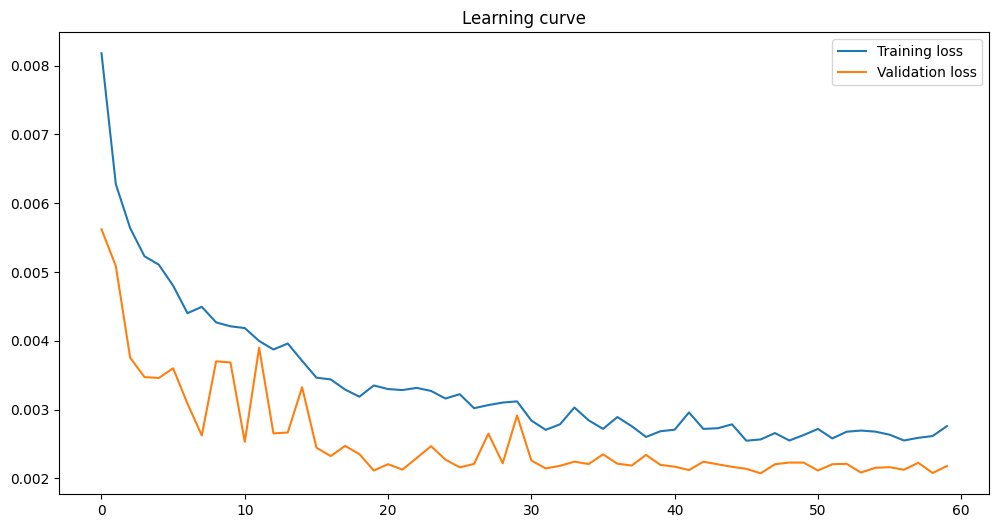

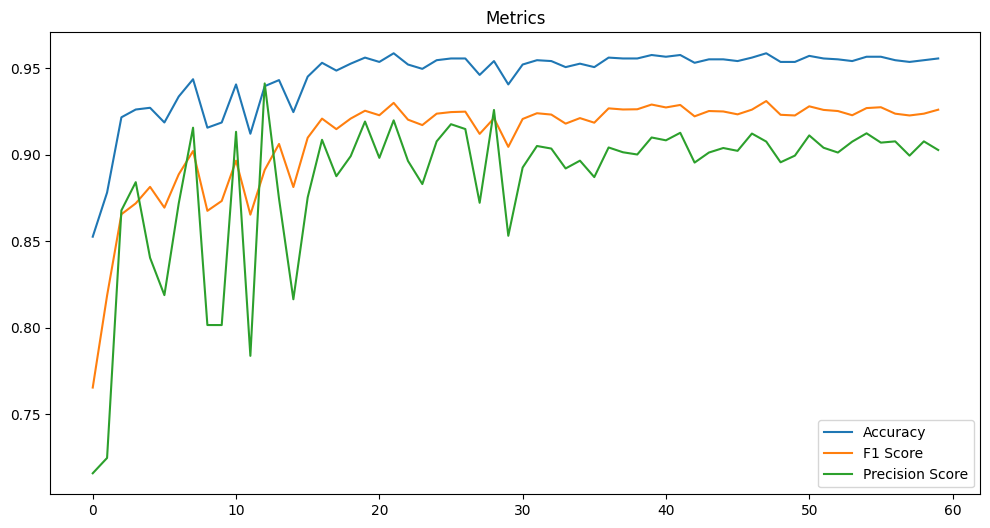

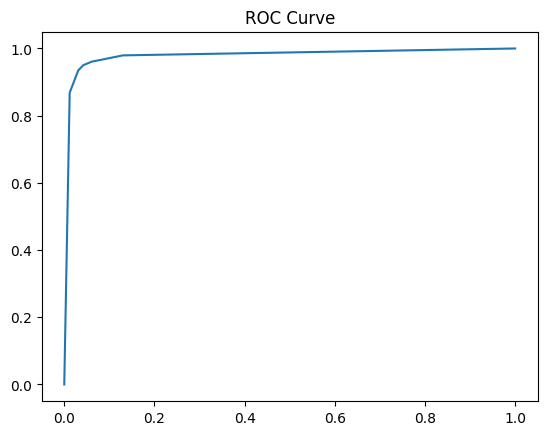

In [22]:
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
loss_function = nn.BCELoss()

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=num_epochs)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.25, verbose=True)
# lr_scheduler = None

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []
prec_all, f1_all, acc_all, auc_all = [], [], [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """
    yp = y_pred
    y_pred = np.round(y_pred)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TPR = TP / np.sum(y_true == 1)
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FPR = FP / np.sum(y_true == 0)
    FN = np.sum((y_true == 1) & (y_pred == 0))

    precision = TP / ((TP + FP) + 1e-6)
    recall = TP / ((TP + FN) + 1e-6)
    f1 = 2 * ((precision * recall) / (precision + recall + 1e-6))
    acc = np.mean(y_true == y_pred)
    f1_all.append(f1)
    prec_all.append(precision)
    acc_all.append(acc)


    tprs, fprs = [], []
    for thr in [0.0, 0.1, 0.33, 0.5, 0.66, 0.9, 1.0]:
        y_pred = yp > thr
        TP = np.sum((y_true == 1) & (y_pred == 1))
        TPR = TP / np.sum(y_true == 1)
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FPR = FP / np.sum(y_true == 0)
        tprs.insert(0, TPR)
        fprs.insert(0, FPR)
    auc = 0.0
    for i in range(1, len(fprs)):
        auc += 0.5 * (fprs[i] - fprs[i-1]) * (tprs[i] + tprs[i-1])
    auc_all.append(auc)



    print(f'AUC: {auc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, Acc: {acc:.3f}')

    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth')
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step()

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""

plt.figure(figsize=(12, 6))
plt.plot(train_loss_all, label='Training loss')
plt.plot(valid_loss_all, label='Validation loss')
plt.title('Learning curve')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(acc_all, label='Accuracy')
plt.plot(f1_all, label='F1 Score')
plt.plot(prec_all, label='Precision Score')
plt.title('Metrics')
plt.legend()
plt.show()

plt.plot(fprs, tprs)
plt.title('ROC Curve')
plt.show()

---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain hard predction (0,1) instead of soft predictions (probabilities).

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The soft and hard predictions are saved in the variables `soft_pred` and `hard_pred`.
- upload your predictions to the leaderboard online (see instruction details below).

In [23]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [24]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()

# load stored model parameters
ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        # test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()
        test_pred[start:end] = model_output.detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

In [ ]:
soft_pred

In [ ]:
hard_pred

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [ ]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

In [ ]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password.
Do not change this after you have registered your team
"""
team_id = 'Team' #Fill in a string
password = 'strongpassword' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")
else:
    print(r.status_code)

200


In [ ]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = 'Bn, bal, lrs, augs' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")
else:
    print(r.status_code)
    print(r.text)


Submission updated!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**
We started with model that is comperatively larger than the baseline model so it is represent the data in more detail. In the next submission (BIG Net + balanced) we aimed to balance the data by sampling the possible classes with a probability that reflects their occurance in the dataset. We also added a learning rate scheduler and tried out different settings for it. Our last submission added bath normalisation layers, and created augmentations of the data. We also removed the previously used sampling to balance the data. This gave us the best result. The main improvement came from using the batch norm, however augmentations also seemed to work better than sampling in improving the F1 score which was what we were trying to do in this last run.

Your team id: **<font color='red'>Team</font>**


| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|BIG Net w/ BN             | 0.941        | 0.940  | 0.982   | 0.980  |BN + augs                   |
|BIG Net + balanced              | 0.918        | 0.916  | 0.980   | 0.978  |balanced + LRS                   |
|BIG Net              | 0.924        | 0.921  | 0.971   | 0.969  |base                   |


### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**

- The data may be in balanced
- Some classes might be more important to predict correctly then others, especially in medicine
- Looking at different metrics that measure different attributes of the result may make the mistakes in the results easier to understand which might help figuring out how to improve the results
- If we only focus on one metric we might not get the full picture of the predictions or not be able to focus on the important part of the predictions. For example if we only track AUC we would only see information about the possitive samples in the data and no information about the negative class or the tradeoffs between possitibe and negative predictions.